In [12]:
import numpy as np
import EFIE as solve
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

frequency = 1e6 * 146
omega, wavelength = 2 * np.pi * frequency, light_speed / frequency
incident_field, radius = 10, 3.175e-3
delta_r = wavelength / 100

class yagi:
    def __init__(self, position, angle, length, source_position, radius):
        self.position = position
        self.angle = angle
        self.length = length
        self.source_position = source_position
        self.radius = radius

class tree:
    def __init__(self, its, phi, length, f, radius, field):
        self.its = its
        self.phi = phi
        self.length = length
        self.f = f
        self.radius = radius
        self.field = field

class circle:
    def __init__(self, R, radius, center, source_position):
        self.R = R
        self.radius = radius
        self.source_position = source_position
        self.center = center

#R = np.array([wavelength/40, wavelength/40])
#radius = np.full(2, 3.175e-3)
#center = np.array([[0.0, 0.0, 0.0], [wavelength/4, 0.0, 0.0]])
#source_position = np.array([[wavelength/10, 0.0, 0.0, incident_field]])
#test_circle = circle(R, radius, center, source_position)

#position = np.array([[0.0, 0.0, 0.0], [0.0, wavelength/10, 0.0]])
#angle = np.array([[np.pi/2, np.pi/4] , [np.pi/2, np.pi/3]])
#length = np.array([wavelength/4, wavelength/4])
#source_position = np.array([[0.0, 0.0, 0.0, incident_field]])
#radii = np.array([radius, radius])
#test_yagi = yagi(position, angle, length, source_position, radii)

#its = 2
#phi = np.full(2*(2**its-1), np.pi/3)
#length = wavelength/10
#f = 1
#radius = 3.175e-3
#field = incident_field
#test_tree = tree(its, phi, length, f, radius, field)

class mixed:
    def __init__(self, yagis=None, trees=None, circles=None):
        self.yagis = yagis if yagis is not None else []
        self.trees = trees if trees is not None else []
        self.circles = circles if circles is not None else []

    def add_yagi(self, yagi_obj):
        self.yagis.append(yagi_obj)

    def add_tree(self, tree_obj):
        self.trees.append(tree_obj)

    def add_circle(self, circle_obj):
        self.circles.append(circle_obj)
        
structure_type = 'mixed'
basis_functions = 'triangle'
test_yagi = yagi(np.array([[0.0,0.0,0.0]]), np.array([[np.pi/2, np.pi/2]]), np.array([wavelength*2]), np.array([[0.0, 0.0, 0.0, incident_field]]), np.array([radius]))
test_tree = tree(3, np.full(2*(2**3-1), np.pi/2), wavelength/10, 1, radius, incident_field)
test_circle = circle(np.array([5*delta_r/np.pi, wavelength/2, wavelength]), np.array([radius, radius, radius]), np.array([[0.0,0.0,0.0], [0.0,0.0,0.0], [0.0,0.0,0.0]]), np.array([]))

test = mixed()
test.add_yagi(test_yagi)
#all_objects.add_tree(test_tree)
#test.add_circle(test_circle)

In [14]:
structure_type = 'tree'
basis_functions = 'triangle'
test_tree = tree(2, np.full(2*(2**2-1), np.pi/2), wavelength/10, 1, radius, incident_field)
I,R,impedance,_,_,_ = solve.calc_current_amplitudes(structure_type, basis_functions, test_tree, frequency, delta_r)

100%|██████████| 7/7 [03:59<00:00, 34.16s/it]


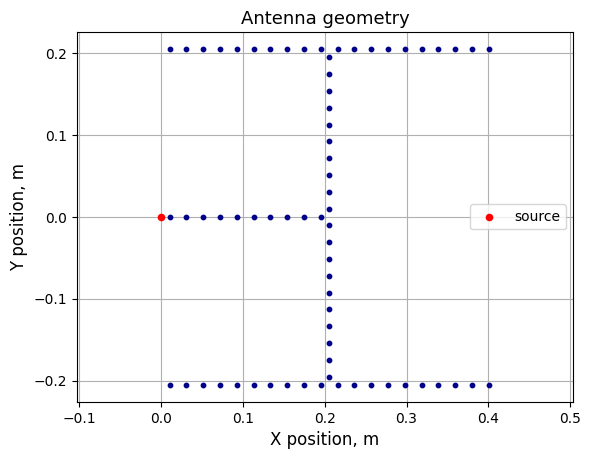

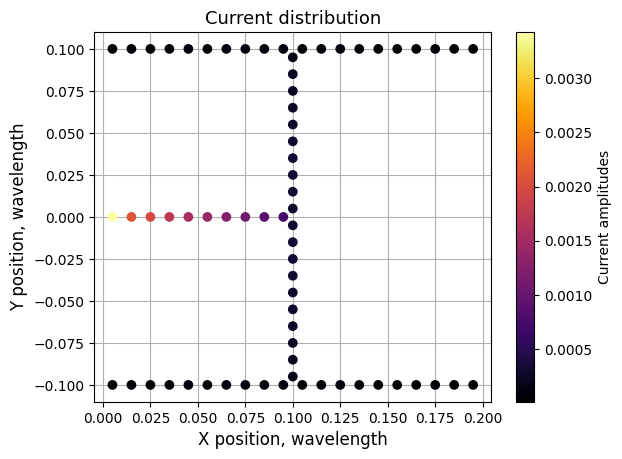

In [15]:
import geometry as gm 
gm.plot_antenna(structure_type, basis_functions, test_tree, delta_r)
gm.plot_distribution(I,R,frequency)

In [27]:
from tqdm import tqdm 
from scipy import linalg 
import scipy.integrate as integrate 
c = light_speed
def basis_func(basis_functions, t_n, r_n, dr_n):
    if basis_functions == 'pulse' :
        return 1
    elif basis_functions == 'triangle':
        if -1/2 <= t_n <= 1/2 :
            return 1/2 + t_n
        elif 1/2 <= t_n <= 3/2 :
            return 3/2 - t_n

def weight_func(basis_functions, t_m, r_m, dr_m):
    if basis_functions == 'pulse' :
        return 1
    elif basis_functions == 'triangle':
        if -1/2 <= t_m <= 1/2 :
            return 1/2 + t_m
        elif 1/2 <= t_m <= 3/2 :
            return 3/2 - t_m

def impedance_real_approx(t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega / c
    t_n = 1/2
    tau_n = dr_n / np.linalg.norm(dr_n)
    tau_m = dr_m / np.linalg.norm(dr_m)
    
    c_0 = (np.dot(tau_m, tau_n))
    c_x = (1/k**2 * tau_n[0] * tau_m[0])
    c_y = (1/k**2 * tau_n[1] * tau_m[1])
    c_z = (1/k**2 * tau_n[2] * tau_m[2])
    c_xy = (1/k**2 * (tau_m[0]*tau_n[1] + tau_m[1]*tau_n[0]))
    c_xz = (1/k**2 * (tau_m[0]*tau_n[2] + tau_m[2]*tau_n[0]))
    c_yz = (1/k**2 * (tau_m[1]*tau_n[2] + tau_m[2]*tau_n[1]))

    C = c_x + c_y + c_z

    rmn =  (np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_n-1/2)))
    dx = (r_m[0] - r_n[0] + dr_m[0]*(t_m-1/2) - dr_n[0]*(t_n-1/2))
    dy = (r_m[1] - r_n[1] + dr_m[1]*(t_m-1/2) - dr_n[1]*(t_n-1/2))
    dz = (r_m[2] - r_n[2] + dr_m[2]*(t_m-1/2) - dr_n[2]*(t_n-1/2))
    L = c_x * dx**2 + c_y * dy**2 + c_z * dz**2 + c_xy * dx * dy + c_xz * dx * dz + c_yz * dy * dz
    
    polypart1 = c_0 * rmn**2 - C + L * (3 - k**2 * rmn**2) / rmn**2
    polypart2 = k * (3 * L / rmn - rmn * C)
    
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    
    return f_n * f_m * (polypart1 * np.cos(k * rmn) + polypart2 * np.sin(k * rmn)) / rmn**3
def impedance_imag_approx (t_m, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega / c
    t_n = 1/2
    tau_n = dr_n / np.linalg.norm(dr_n)
    tau_m = dr_m / np.linalg.norm(dr_m)
    
    c_0 = (np.dot(tau_m, tau_n))
    c_x = (1/k**2 * tau_n[0] * tau_m[0])
    c_y = (1/k**2 * tau_n[1] * tau_m[1])
    c_z = (1/k**2 * tau_n[2] * tau_m[2])
    c_xy = (1/k**2 * (tau_m[0]*tau_n[1] + tau_m[1]*tau_n[0]))
    c_xz = (1/k**2 * (tau_m[0]*tau_n[2] + tau_m[2]*tau_n[0]))
    c_yz = (1/k**2 * (tau_m[1]*tau_n[2] + tau_m[2]*tau_n[1]))

    C = c_x + c_y + c_z

    rmn =  (np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_n-1/2)))
    dx = (r_m[0] - r_n[0] + dr_m[0]*(t_m-1/2) - dr_n[0]*(t_n-1/2))
    dy = (r_m[1] - r_n[1] + dr_m[1]*(t_m-1/2) - dr_n[1]*(t_n-1/2))
    dz = (r_m[2] - r_n[2] + dr_m[2]*(t_m-1/2) - dr_n[2]*(t_n-1/2))
    L = c_x * dx**2 + c_y * dy**2 + c_z * dz**2 + c_xy * dx * dy + c_xz * dx * dz + c_yz * dy * dz
    
    polypart1 = c_0 * rmn**2 - C + L * (3 - k**2 * rmn**2) / rmn**2
    polypart2 = k * (3 * L / rmn - rmn * C)
    
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    
    return f_n * f_m * (-polypart1 * np.sin(k * rmn) + polypart2 * np.cos(k * rmn)) / rmn**3


def impedance_real(t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega / c
    
    tau_n = dr_n / np.linalg.norm(dr_n)
    tau_m = dr_m / np.linalg.norm(dr_m)
    
    c_0 = (np.dot(tau_m, tau_n))
    c_x = (1/k**2 * tau_n[0] * tau_m[0])
    c_y = (1/k**2 * tau_n[1] * tau_m[1])
    c_z = (1/k**2 * tau_n[2] * tau_m[2])
    c_xy = (1/k**2 * (tau_m[0]*tau_n[1] + tau_m[1]*tau_n[0]))
    c_xz = (1/k**2 * (tau_m[0]*tau_n[2] + tau_m[2]*tau_n[0]))
    c_yz = (1/k**2 * (tau_m[1]*tau_n[2] + tau_m[2]*tau_n[1]))

    C = c_x + c_y + c_z

    rmn =  (np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_n-1/2)))
    dx = (r_m[0] - r_n[0] + dr_m[0]*(t_m-1/2) - dr_n[0]*(t_n-1/2))
    dy = (r_m[1] - r_n[1] + dr_m[1]*(t_m-1/2) - dr_n[1]*(t_n-1/2))
    dz = (r_m[2] - r_n[2] + dr_m[2]*(t_m-1/2) - dr_n[2]*(t_n-1/2))
    L = c_x * dx**2 + c_y * dy**2 + c_z * dz**2 + c_xy * dx * dy + c_xz * dx * dz + c_yz * dy * dz
    
    polypart1 = c_0 * rmn**2 - C + L * (3 - k**2 * rmn**2) / rmn**2
    polypart2 = k * (3 * L / rmn - rmn * C)
    
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    
    return f_n * f_m * (polypart1 * np.cos(k * rmn) + polypart2 * np.sin(k * rmn)) / rmn**3
def impedance_imag (t_m, t_n, r_m, r_n, dr_m, dr_n, omega, basis_functions):
    k = omega / c
    
    tau_n = dr_n / np.linalg.norm(dr_n)
    tau_m = dr_m / np.linalg.norm(dr_m)
    
    c_0 = (np.dot(tau_m, tau_n))
    c_x = (1/k**2 * tau_n[0] * tau_m[0])
    c_y = (1/k**2 * tau_n[1] * tau_m[1])
    c_z = (1/k**2 * tau_n[2] * tau_m[2])
    c_xy = (1/k**2 * (tau_m[0]*tau_n[1] + tau_m[1]*tau_n[0]))
    c_xz = (1/k**2 * (tau_m[0]*tau_n[2] + tau_m[2]*tau_n[0]))
    c_yz = (1/k**2 * (tau_m[1]*tau_n[2] + tau_m[2]*tau_n[1]))

    C = c_x + c_y + c_z

    rmn =  (np.linalg.norm(r_m - r_n + dr_m*(t_m-1/2) - dr_n*(t_n-1/2)))
    dx = (r_m[0] - r_n[0] + dr_m[0]*(t_m-1/2) - dr_n[0]*(t_n-1/2))
    dy = (r_m[1] - r_n[1] + dr_m[1]*(t_m-1/2) - dr_n[1]*(t_n-1/2))
    dz = (r_m[2] - r_n[2] + dr_m[2]*(t_m-1/2) - dr_n[2]*(t_n-1/2))
    L = c_x * dx**2 + c_y * dy**2 + c_z * dz**2 + c_xy * dx * dy + c_xz * dx * dz + c_yz * dy * dz
    
    polypart1 = c_0 * rmn**2 - C + L * (3 - k**2 * rmn**2) / rmn**2
    polypart2 = k * (3 * L / rmn - rmn * C)
    
    f_n = basis_func(basis_functions=basis_functions, t_n=t_n, r_n=r_n, dr_n=dr_n)
    f_m = weight_func(basis_functions=basis_functions, t_m=t_m, r_m=r_m, dr_m=dr_m)
    
    return f_n * f_m * (-polypart1 * np.sin(k * rmn) + polypart2 * np.cos(k * rmn)) / rmn**3

def Zmn (structure_type, basis_functions, m, n, i, j, segments_block, omega, delta_r):

    if basis_functions == 'pulse' :
        t_min, t_max = 0, 1
    elif basis_functions == 'triangle' :
        t_min, t_max = -1/2, 3/2
        
    a_m = segments_block[m][i].radius
    a_n = segments_block[n][j]. radius
    
    tau_m = segments_block[m][i].tau
    tau_n = segments_block[n][j].tau
    
    r_m = segments_block[m][i].position 
    r_n = segments_block[n][j].position 
    
    r_n = r_n + a_n * np.array([0,0,1])

    dr_m = delta_r * tau_m
    dr_n = delta_r * tau_n
    
    return 1j*omega*mu0 / (4*np.pi) * delta_r **2 * (integrate.dblquad(impedance_real, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args=(r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.dblquad(impedance_imag, t_min, t_max, lambda z1: t_min, lambda z2: t_max, args=(r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])

def Zmn_approx (structure_type, basis_functions, m, n, i, j, segments_block, omega, delta_r):

    if basis_functions == 'pulse' :
        t_min, t_max = 0, 1
    elif basis_functions == 'triangle' :
        t_min, t_max = -1/2, 3/2
        
    a_m = segments_block[m][i].radius
    a_n = segments_block[n][j]. radius
    
    tau_m = segments_block[m][i].tau
    tau_n = segments_block[n][j].tau
    
    r_m = segments_block[m][i].position 
    r_n = segments_block[n][j].position 
    
    r_n = r_n + a_n * np.array([0,0,1])

    dr_m = delta_r * tau_m
    dr_n = delta_r * tau_n
    
    return 1j*omega*mu0 / (4*np.pi) * delta_r **2 * (integrate.quad(impedance_real_approx, t_min, t_max, args=(r_m, r_n, dr_m, dr_n, omega, basis_functions))[0] + 1j * integrate.quad(impedance_imag_approx, t_min, t_max, args=(r_m, r_n, dr_m, dr_n, omega, basis_functions))[0])

from tqdm import tqdm 
import geometry as gm

num = np.linspace(10, 1000, 10)
dr = wavelength / num
Z_dr = []
Z_approx_dr = []
distance_dr = []

for j in range(len(dr)):
    delta_r = dr[j]
    Z = []
    Z_approx = []
    distance = []

    segments_block, source_position = gm.antenna_to_segments(structure_type,test,basis_functions,delta_r)

    for m in range(len(segments_block)):
        for i in tqdm(range(len(segments_block[m]))):
            dist = np.linalg.norm(segments_block[0][0].position - segments_block[m][i].position)
            Z_i = Zmn(structure_type,basis_functions,m,0,i,0,segments_block,omega,delta_r)
            Z_approx_i = Zmn_approx(structure_type,basis_functions,m,0,i,0,segments_block,omega,delta_r)
            Z.append(Z_i)
            Z_approx.append(Z_approx_i)
            distance.append(dist)
            
    Z = np.array(Z)
    Z_approx = np.array(Z_approx)
    distance = np.array(distance)
    
    Z_dr.append(Z)
    Z_approx_dr.append(Z_approx)
    distance_dr.append(distance)
    
Z_dr = np.array(Z_dr, dtype=object)
Z_approx_dr = np.array(Z_approx_dr, dtype=object)
distance_dr = np.array(distance_dr, dtype=object)
    

100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]


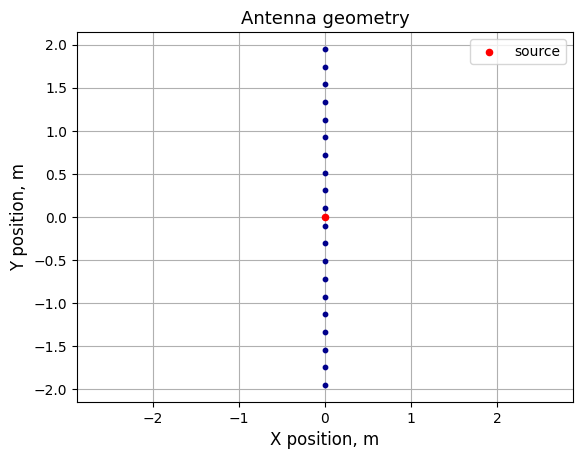

In [23]:
gm.plot_antenna(structure_type,basis_functions,test,delta_r)

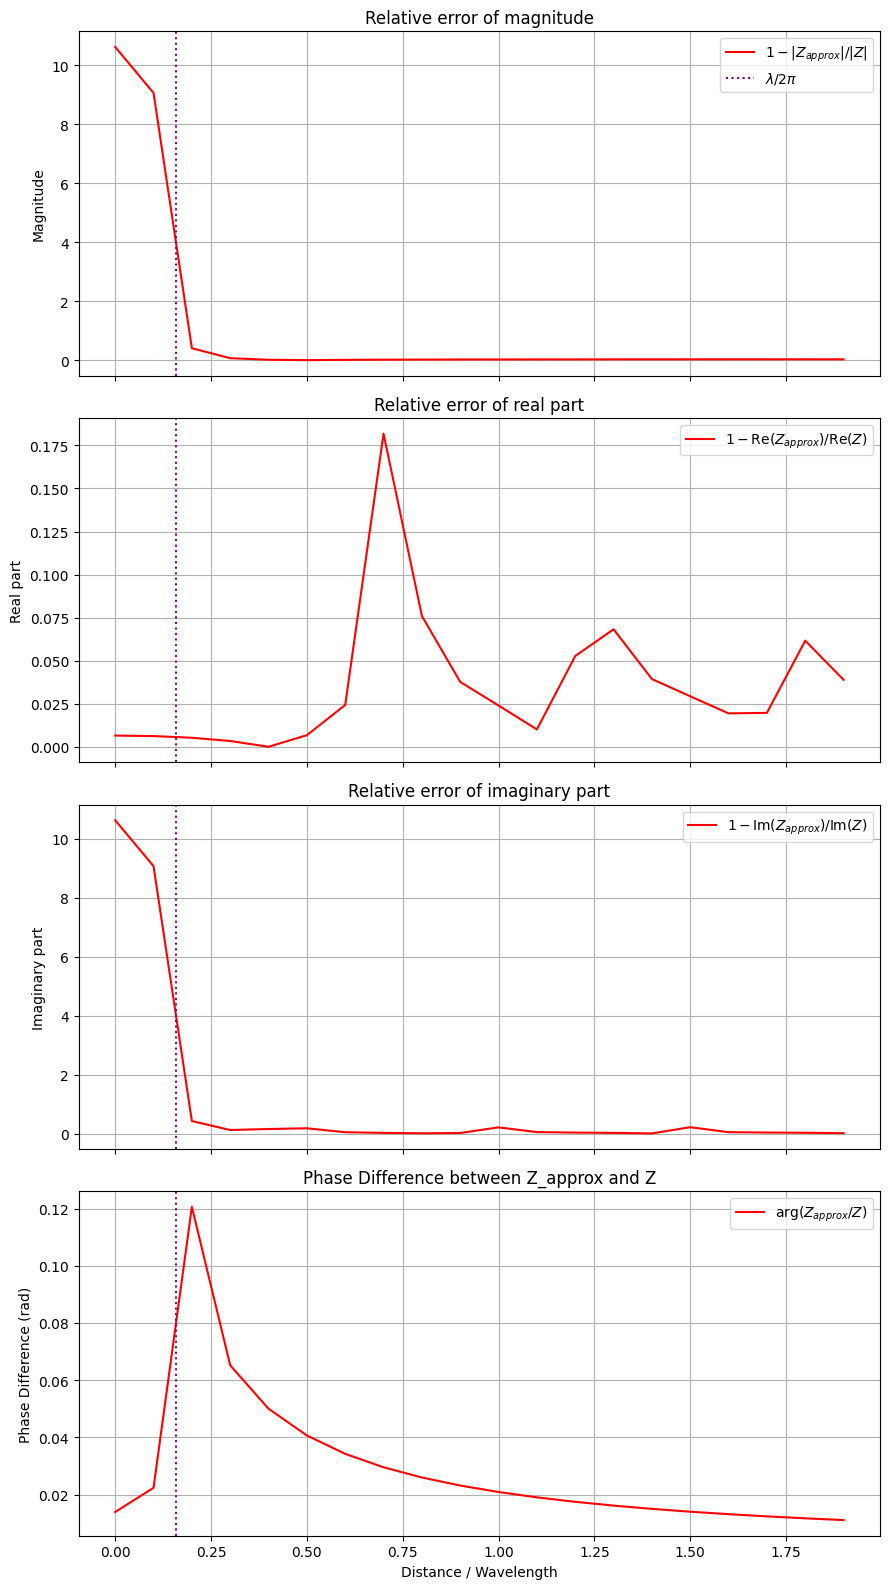

In [25]:
import matplotlib.pyplot as plt
import numpy as np

x = distance / wavelength
x_vertline = 1 / (2 * np.pi)

rel_err_mag = 1 - np.abs(Z_approx) / (np.abs(Z))
rel_err_real = 1 - Z_approx.real / (Z.real)
rel_err_imag = 1 - Z_approx.imag / (Z.imag)

phase_diff = np.angle(Z_approx / Z)

fig, axes = plt.subplots(4, 1, figsize=(9, 16), sharex=True)

axes[0].plot(x, np.abs(rel_err_mag), 'r-', label=r'$1 - |Z_{approx}|/|Z|$')
axes[0].set_ylabel('Magnitude')
axes[0].grid(True)
axes[0].legend()
axes[0].set_title('Relative error of magnitude')

axes[1].plot(x, np.abs(rel_err_real), 'r-', label=r'$1 - \mathrm{Re}(Z_{approx})/\mathrm{Re}(Z)$')
axes[1].set_ylabel('Real part')
axes[1].grid(True)
axes[1].legend()
axes[1].set_title('Relative error of real part')

axes[2].plot(x, np.abs(rel_err_imag), 'r-', label=r'$1 - \mathrm{Im}(Z_{approx})/\mathrm{Im}(Z)$')
axes[2].set_ylabel('Imaginary part')
axes[2].grid(True)
axes[2].legend()
axes[2].set_title('Relative error of imaginary part')

axes[3].plot(x, np.abs(phase_diff), 'r-', label=r'$\arg(Z_{approx}/Z)$')
axes[3].set_xlabel('Distance / Wavelength')
axes[3].set_ylabel('Phase Difference (rad)')
axes[3].grid(True)
axes[3].legend()
axes[3].set_title('Phase Difference between Z_approx and Z')

for ax in axes:
    ax.axvline(x=x_vertline, color='purple', linestyle=':', label=r'$\lambda / 2\pi$')

#for ax in axes:
#    ax.set_yscale('log')
#    ax.set_xscale('log')

# Легенду с вертикальной линией выводим только в первом subplot
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels)

plt.tight_layout()
plt.show()
